In [1]:
%matplotlib inline

import itertools
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from PIL import Image
from sklearn.metrics import confusion_matrix

import keras.backend as K
from keras.models import Model

from net import load_model
from utils import load_data

Using Theano backend.
Using gpu device 2: Tesla K80 (CNMeM is disabled, cuDNN 4007)


In [2]:
sns.set_style('ticks')
sns.set_context('paper', font_scale=2.0, rc={
    'axes.linewidth': 2.0,
    'lines.linewidth': 2.0,
    'font.family': 'Helvetica',
})

In [3]:
model = load_model('models/model.json', 'models/checkpoints/weights_079_0.98.h5')

/home/nagano/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer softmax and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 10)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [4]:
(X_train, Y_train), (X_test, Y_test) = load_data('data/cluttered_mnist.h5', img_size=(96, 96))

X_train shape: (50000, 1, 96, 96)
50000 train samples
10000 test samples


In [5]:
Y_pred = model.predict(X_test)

In [6]:
y_test = np.argmax(Y_test, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 size=10,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 968    1    0    0    0    2    4    2    1    2]
 [   0 1115    0    1    3    1    1   11    0    3]
 [   2    0 1006    2    1    0    2   14    4    1]
 [   2    0    0 1006    0    0    0    1    0    1]
 [   0    3    0    0  963    0    2    1    0   13]
 [   1    1    0    7    0  874    3    1    0    5]
 [   1    6    0    0    1    4  946    0    0    0]
 [   1    2    6    0    5    0    0 1010    0    4]
 [   1    1    0    1    1    2    0    0  959    9]
 [   0    1    1    1    1    3    2    2    1  997]]


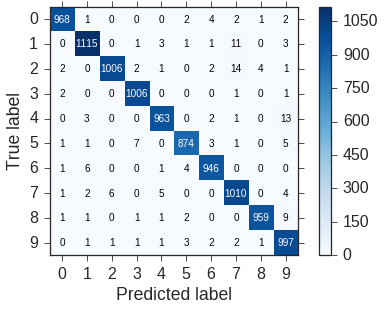

In [8]:
C = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(C, range(10))
plt.savefig('images/confusion_matrix.pdf', bbox_inches='tight')

In [9]:
history = pd.read_csv('models/history/log.tsv')
history[:5]

,epoch,acc,loss,val_acc,val_loss
0,0,0.20668,91074.344313,0.1135,91032.072158
1,1,0.61500,91030.939750,0.4956,91031.198045
2,2,0.85310,91030.229213,0.7466,91030.519887
3,3,0.90456,91030.013901,0.8608,91030.211946
4,4,0.92620,91029.924321,0.6487,91030.771467


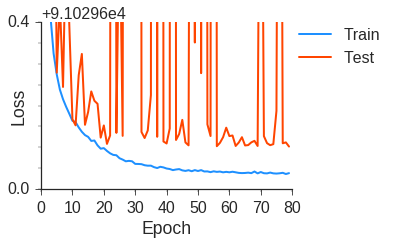

In [11]:
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_subplot(111)
plt.plot(history['epoch'], history['loss'], color='dodgerblue', label='Train')
plt.plot(history['epoch'], history['val_loss'], color='orangered', label='Test')
plt.ylim(91029.6, 91030)
sns.despine()
plt.yticks([0+9.10296e4, 0.4+9.10296e4])
ax.xaxis.set_minor_locator(mpl.ticker.AutoLocator())
ax.yaxis.set_minor_locator(mpl.ticker.AutoLocator())
plt.ylabel('Loss', labelpad=-20)
plt.xlabel('Epoch')
plt.legend(loc=(1.0, 0.7))
plt.savefig('images/losses.pdf', bbox_inches='tight')

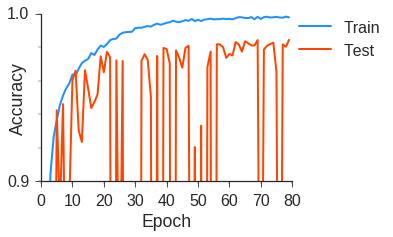

In [12]:
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_subplot(111)
plt.plot(history['epoch'], history['acc'], color='dodgerblue', label='Train')
plt.plot(history['epoch'], history['val_acc'], color='orangered', label='Test')
plt.ylim(0.9, 1.0)
sns.despine()
plt.yticks([0.9, 1.0])
ax.xaxis.set_minor_locator(mpl.ticker.AutoLocator())
ax.yaxis.set_minor_locator(mpl.ticker.AutoLocator())
plt.ylabel('Accuracy', labelpad=-20)
plt.xlabel('Epoch')
plt.legend(loc=(1.0, 0.7))
plt.savefig('images/accuracies.pdf', bbox_inches='tight')

In [13]:
def get_weight_at(name):
    return K.get_value(model.get_layer(name).W)

def plot_weight(W, padding=2, rescale=10.0):
    nb_filter_in, nb_filter_out, original_kernel_w, original_kernel_h = W.shape
    kernel_w = int(original_kernel_w * rescale)
    kernel_h = int(original_kernel_h * rescale)
    n = nb_filter_out * nb_filter_in
    width = int(np.ceil(np.sqrt(n)))
    height = int(np.ceil(np.sqrt(n)))
    CANVAS_SIZE = (
        kernel_w*width + padding*(width+1),
        kernel_h*height + padding*(height+1)
    )
    clip = 1.0

    W_norm = (
        W.reshape(-1, original_kernel_w, original_kernel_h)
        - W.reshape(-1, original_kernel_w, original_kernel_h).min() * clip
    )
    W_norm = W_norm / (W_norm.max() * clip) * 255.

    canvas = Image.new('L', size=CANVAS_SIZE, color='white')
    for i in range(width):
        for j in range(height):

            if i*height+j >= n:
                break
            img = Image.fromarray(
                np.uint8(W_norm[i*height+j, :, :]), mode='L'
            ).resize((kernel_w, kernel_h), Image.NEAREST)
            canvas.paste(
                img, (
                    kernel_w*i + padding*(i+1),
                    kernel_h*j + padding*(j+1)
                )
            )
    return canvas

In [14]:
print('Layer names:')
print([l.name for l in model.layers])

Layer names:
['input', 'block0-conv0', 'block0-bn0', 'block0-relu0', 'block0-conv1', 'block0-bn1', 'block0-relu1', 'block0-conv2', 'block0-bn2', 'block0-relu2', 'block0-logalpha', 'block0-z', 'block1-conv0', 'block1-bn0', 'block1-relu0', 'block1-conv1', 'block1-bn1', 'block1-relu1', 'block1-conv2', 'block1-bn2', 'block1-relu2', 'block1-logalpha', 'block1-z', 'block2-conv0', 'block2-bn0', 'block2-relu0', 'block2-conv1', 'block2-bn1', 'block2-relu1', 'block2-conv2', 'block2-bn2', 'block2-relu2', 'block2-logalpha', 'block2-z', 'block3-conv0', 'block3-bn0', 'block3-relu0', 'block3-conv1', 'block3-bn1', 'block3-relu1', 'block3-conv2', 'block3-bn2', 'block3-relu2', 'block3-logalpha', 'block3-z', 'block4-conv0', 'block4-bn0', 'block4-relu0', 'block4-conv1', 'block4-bn1', 'block4-relu1', 'block4-conv2', 'block4-bn2', 'block4-relu2', 'spatial-average', 'softmax']


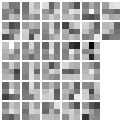

In [15]:
W = get_weight_at('block0-conv0')
canvas = plot_weight(W, rescale=6)
canvas.save('images/weight_block0-conv0.png')
canvas

block0-conv0
block0-conv1
block0-conv2
block1-conv0
block1-conv1
block1-conv2


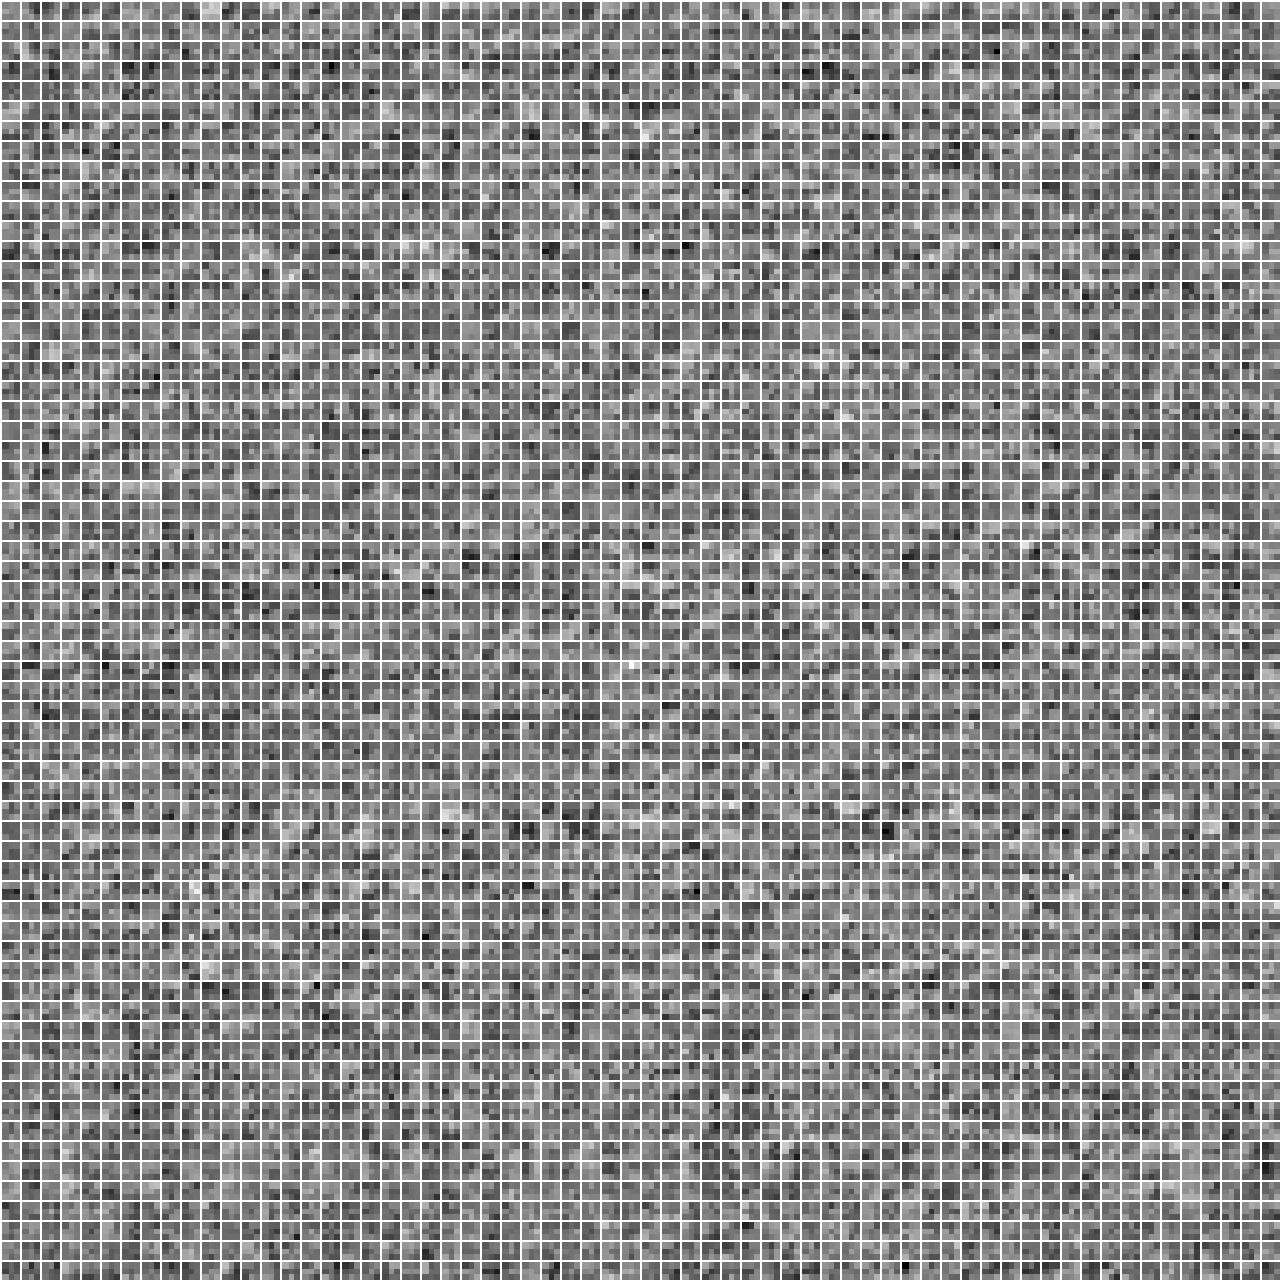

In [16]:
blocks = [0, 1]
convs = [0, 1, 2]

for block in blocks:
    for conv in convs:
        print('block{}-conv{}'.format(block, conv))
        W = get_weight_at('block{}-conv{}'.format(block, conv))
        canvas = plot_weight(W, rescale=6)
        canvas.save('images/weight_block{}-conv{}.png'.format(block, conv))
canvas

In [17]:
attention = Model(
    input=model.get_layer('input').output,
    output=[
        model.get_layer('block0-logalpha').output,
        model.get_layer('block1-logalpha').output,
        model.get_layer('block2-logalpha').output,
        model.get_layer('block3-logalpha').output
    ]
)

([], <a list of 0 Text yticklabel objects>)

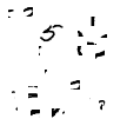

In [18]:
img_size = (96, 96)
x = X_test[3, :, :, :]

fig = plt.figure(figsize=(2,2))
plt.imshow(x.reshape(img_size))
plt.box('off')
plt.xticks([])
plt.yticks([])

In [19]:
logalphas = attention.predict(x.reshape(-1, 1, img_size[0], img_size[1]))

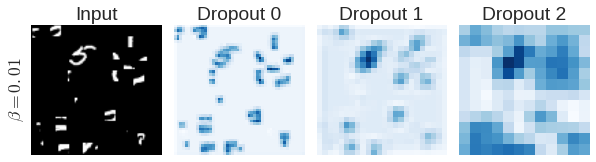

In [20]:
fig = plt.figure(figsize=(10, 3))
fig.subplots_adjust(wspace=0.1)

ax0 = fig.add_subplot(141)
plt.imshow(1-x.reshape(img_size))
plt.box('off')
plt.xticks([])
plt.yticks([])
plt.title('Input')
plt.ylabel(r'$\beta=0.01$')

ax1 = fig.add_subplot(142)
do0 = logalphas[0].mean(axis=1)[0]
plt.imshow(do0, cmap=mpl.cm.Blues, interpolation='nearest')
plt.box('off')
plt.xticks([])
plt.yticks([])
plt.title('Dropout 0')

ax2 = fig.add_subplot(143)
do1 = logalphas[1].mean(axis=1)[0]
plt.imshow(do1, cmap=mpl.cm.Blues, interpolation='nearest')
plt.box('off')
plt.xticks([])
plt.yticks([])
plt.title('Dropout 1')

ax3 = fig.add_subplot(144)
do2 = logalphas[2].mean(axis=1)[0]
plt.imshow(do2, cmap=mpl.cm.Blues, interpolation='nearest')
plt.box('off')
plt.xticks([])
plt.yticks([])
plt.title('Dropout 2')

plt.savefig('images/kldiv_heatmap.pdf', bbox_inches='tight')